# swin3d_b (all 1000 classes)

In [1]:
#%%python3 -m pip install --upgrade pip

In [1]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import sys
sys.path.append("..")
from train_utils import VideoDataset, validate_model, validate_model_batched, train_model, display_frames

2024-03-04 19:36:02.266646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 19:36:07.059250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by call

In [3]:
import torch
import numpy as np
import pandas as pd
import random
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [4]:
torch.cuda.is_available()

True

In [5]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [6]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv" #  "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir = "/home/jupyter/mnt/s3/rsl-videos/slovo/" #  "/content/drive/MyDrive/slovo/dataloaders/" #

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path = "/home/jupyter/mnt/s3/rsl-videos/slovo/models/all/swinb" #'/content/drive/MyDrive/slovo/models/ResNet18' # '/content/model' #

In [7]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,attachment_id,text,user_id,height,width,length,begin,end,group_rank,dataset
19995,81cab3c3-80be-4eb1-b3bf-fd1b69034a16,отложенный,4d26ad833542291c50de9ce88fb4f64a,640,360,131.0,12,73,20,test
19996,4eeeea02-df4c-4667-872e-8387ed31c32e,башенные часы,3018b64d2c938f5b6a0826dfdf486f2c,640,360,145.0,17,83,20,test
19997,d947ab2e-0b6e-4ea7-a5dd-b401c572d177,дважды,3018b64d2c938f5b6a0826dfdf486f2c,640,360,127.0,13,63,20,test
19998,03edb6f1-1c91-46ce-8394-b74bca3b3cd7,время от 0 ночи до 12 дня,472fb939766ece63eb06e2d0e10eb679,840,358,178.0,16,138,19,test
19999,5393ec0c-85a4-4980-a2da-e84259050d83,время от 0 ночи до 12 дня,30eae85220a3d47b79b9955a08d31d63,640,360,205.0,32,172,20,test


In [8]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 1000. Example classes: ('Ё', 'А', 'Р', 'Е', 'Ч')


In [9]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 16000 videos
Val dataloader contains: 2000 videos


In [10]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


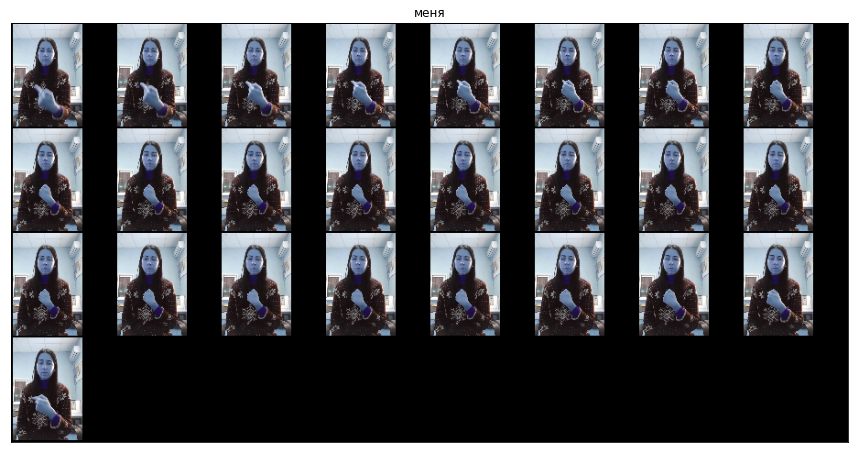

In [11]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [12]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
# frames = frames.permute(0,2,1,3,4) # (B, T, C, H, W) for swin
# print(f"Frames shape: {frames.shape}") #
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([191])


# Set batch_size to 16

In [13]:
bs = 16
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

16 16


# Swin CosineAnnealingLR 3 * (10**(-5)) + horizontal flip

In [16]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

Downloading: "https://download.pytorch.org/models/swin3d_b_22k-7c6ae6fa.pth" to /tmp/xdg_cache/torch/hub/checkpoints/swin3d_b_22k-7c6ae6fa.pth
100%|██████████| 364M/364M [00:09<00:00, 39.7MB/s] 


Linear(in_features=1024, out_features=1000, bias=True)

In [17]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_all_lrcd{lr_power}_bs{bs}_flip"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=6.9238; val acc=0.002, lr=0.0000299178 : 0.0000299178
Train Epoch 2/30: train_loss=6.6726; val acc=0.040, lr=0.0000296722 : 0.0000296722
Train Epoch 3/30: train_loss=4.3733; val acc=0.190, lr=0.0000292658 : 0.0000292658
Train Epoch 4/30: train_loss=2.6338; val acc=0.305, lr=0.0000287032 : 0.0000287032
Train Epoch 5/30: train_loss=1.6114; val acc=0.354, lr=0.0000279904 : 0.0000279904
Train Epoch 6/30: train_loss=0.9726; val acc=0.392, lr=0.0000271353 : 0.0000271353
Train Epoch 7/30: train_loss=0.605; val acc=0.388, lr=0.0000261472 : 0.0000261472
Train Epoch 8/30: train_loss=0.3712; val acc=0.395, lr=0.0000250370 : 0.0000250370
Train Epoch 9/30: train_loss=0.2383; val acc=0.411, lr=0.0000238168 : 0.0000238168
Train Epoch 10/30: train_loss=0.1729; val acc=0.402, lr=0.0000225000 : 0.0000225000
Train Epoch 11/30: train_loss=0.1183; val acc=0.401, lr=0.0000211010 : 0.0000211010
Train Epoch 12/30: train_loss=0.0914; val acc=0.418, lr=0.0000196353 : 0.0000196353
Tr

# Swin CosineAnnealingLR 3 * (10**(-5)) + horizontal flip + perspective_transform

In [29]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

Linear(in_features=1024, out_features=1000, bias=True)

In [30]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_all_lrcd{lr_power}_bs{bs}_flip_pt"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True, perspective_transform=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=6.9228; val acc=0.002, lr=0.0000299178 : 0.0000299178
Train Epoch 2/30: train_loss=6.0637; val acc=0.067, lr=0.0000296722 : 0.0000296722
Train Epoch 3/30: train_loss=4.1119; val acc=0.196, lr=0.0000292658 : 0.0000292658
Train Epoch 4/30: train_loss=2.9199; val acc=0.281, lr=0.0000287032 : 0.0000287032
Train Epoch 5/30: train_loss=2.1139; val acc=0.325, lr=0.0000279904 : 0.0000279904
Train Epoch 6/30: train_loss=1.559; val acc=0.383, lr=0.0000271353 : 0.0000271353
Train Epoch 7/30: train_loss=1.2172; val acc=0.396, lr=0.0000261472 : 0.0000261472
Train Epoch 8/30: train_loss=0.9656; val acc=0.423, lr=0.0000250370 : 0.0000250370
Train Epoch 9/30: train_loss=0.7654; val acc=0.437, lr=0.0000238168 : 0.0000238168
Train Epoch 10/30: train_loss=0.6117; val acc=0.438, lr=0.0000225000 : 0.0000225000
Train Epoch 11/30: train_loss=0.5157; val acc=0.449, lr=0.0000211010 : 0.0000211010
Train Epoch 12/30: train_loss=0.4353; val acc=0.475, lr=0.0000196353 : 0.0000196353
Tr

# Swin CosineAnnealingLR 3 * (10**(-5)) + horizontal flip + perspective_transform + color jitter

In [14]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

Downloading: "https://download.pytorch.org/models/swin3d_b_22k-7c6ae6fa.pth" to /tmp/xdg_cache/torch/hub/checkpoints/swin3d_b_22k-7c6ae6fa.pth
100%|██████████| 364M/364M [00:06<00:00, 58.1MB/s] 


Linear(in_features=1024, out_features=1000, bias=True)

In [15]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_all_lrcd{lr_power}_bs{bs}_flip_pt_col"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True, perspective_transform=True, color_jitter=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=6.9237; val acc=0.001, lr=0.0000299178 : 0.0000299178
Train Epoch 2/30: train_loss=6.2856; val acc=0.064, lr=0.0000296722 : 0.0000296722
Train Epoch 3/30: train_loss=4.3113; val acc=0.183, lr=0.0000292658 : 0.0000292658
Train Epoch 4/30: train_loss=3.157; val acc=0.277, lr=0.0000287032 : 0.0000287032
Train Epoch 5/30: train_loss=2.3711; val acc=0.350, lr=0.0000279904 : 0.0000279904
Train Epoch 6/30: train_loss=1.8392; val acc=0.375, lr=0.0000271353 : 0.0000271353
Train Epoch 7/30: train_loss=1.4437; val acc=0.415, lr=0.0000261472 : 0.0000261472
Train Epoch 8/30: 

# Swin CosineAnnealingLR 3 * (10**(-5)) + horizontal flip + perspective_transform + color jitter + blur

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_all_lrcd{lr_power}_bs{bs}_flip_pt_col_blur"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True, perspective_transform=True, color_jitter=True, blur=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

In [22]:
print(2)

2
